# Load libraries and data

In [ ]:
import pandas as pd
import numpy as np
import os 
import re
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report


In [163]:
churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Exploring the Data and Data Types

In [164]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 🧾 1. 客户信息字段
| 字段名             | 类型         | 说明                    |
| --------------- | ---------- | --------------------- |
| `customerID`    | 字符串（ID）    | 唯一标识符，无建模价值，应该从模型中剔除  |
| `gender`        | 类别         | 男/女，可能与流失略有关联（但通常作用小） |
| `SeniorCitizen` | 数值（0/1）    | 是否为老年人（可视作布尔变量）       |
| `Partner`       | 类别（Yes/No） | 是否有配偶（可能影响留存意愿）       |
| `Dependents`    | 类别（Yes/No） | 是否有家属/小孩，表示经济负担情况     |

### ⏳ 2. 服务使用相关
| 字段名                | 类型               | 说明                       |
| ------------------ | ---------------- | ------------------------ |
| `tenure`           | 数值型              | 使用了几个月，**非常关键特征**        |
| `PhoneService`     | 类别（Yes/No）       | 是否有电话服务                  |
| `MultipleLines`    | 类别               | 是否有多条电话线                 |
| `InternetService`  | 类别（DSL/Fiber/No） | 上网类型，**Fiber 用户流失率往往更高** |
| `OnlineSecurity`   | 类别               | 是否订购网络安全服务               |
| `DeviceProtection` | 类别               | 是否有设备保护服务                |
| `TechSupport`      | 类别               | 是否订购技术支持                 |
| `StreamingTV`      | 类别               | 是否使用电视流媒体服务              |
| `StreamingMovies`  | 类别               | 是否使用电影流媒体服务              |

### 📃 3. 合同与付费相关
| 字段名                | 类型                                     | 说明                     |
| ------------------ | -------------------------------------- | ---------------------- |
| `Contract`         | 类别（Month-to-month, One year, Two year） | **重要特征**，长期合同客户流失率显著较低 |
| `PaperlessBilling` | 类别（Yes/No）                             | 是否无纸账单（可能关联客户行为习惯）     |
| `PaymentMethod`    | 类别                                     | 支付方式（信用卡、银行转账、电子支票等）   |
| `MonthlyCharges`   | 数值型                                    | 每月收费金额，高额可能增加流失风险      |
| `TotalCharges`     | 数值型                                    | 总计花费，部分缺失值需清洗处理        |


In [165]:
churn_data.info()
print(churn_data.shape)
churn_data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

TotalCharges 应该为float64但data文件中是object

# Missing values

In [166]:
# 将 TotalCharges 列转换为数值类型，无法转换的值将被设置为 NaN
churn_data.TotalCharges = pd.to_numeric(churn_data.TotalCharges, errors='coerce')

print(churn_data.isnull().sum())
print('There are {} rows with missing values'.format(churn_data[churn_data.isnull().any(axis=1)].shape[0]))
# missing_rows_index = churn_data[churn_data.TotalCharges.isnull()].index.tolist()
# churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') 
# print(churn_data.iloc[missing_rows_index]) 

# 删除 TotalCharges 列中有缺失值的行
churn_data = churn_data.dropna(subset=['TotalCharges'])
# 还有哪些行的 tenure 为 0
churn_data[churn_data.tenure == 0].index

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
There are 11 rows with missing values


Index([], dtype='int64')

TotalCharges 里面有缺失值是因为有刚注册的用户，tenure为。因为只分析长期使用而流失的客户，所以将这11个用户删除。

# Data manipulation

- 将customerID 设为index
- 将SeniorCitizen 的0,1 改为分类变量

In [167]:
try:
    churn_data = churn_data.set_index('customerID')
except:
    print("customerID column not found or already set as index.")

churn_data.rename(columns = {'gender': 'Gender'}, inplace=True)
churn_data.Gender = churn_data.Gender.astype('category')
churn_data.SeniorCitizen = churn_data.SeniorCitizen.map({1: 'Yes', 0: 'No'}).astype('category')
churn_data.Partner = churn_data.Partner.astype('category')
churn_data.Dependents = churn_data.Dependents.astype('category')
churn_data.PhoneService = churn_data.PhoneService.astype('category')
churn_data.MultipleLines = churn_data.MultipleLines.astype('category')
churn_data.InternetService = churn_data.InternetService.astype('category')
churn_data.OnlineSecurity = churn_data.OnlineSecurity.astype('category')
churn_data.OnlineBackup = churn_data.OnlineBackup.astype('category')
churn_data.DeviceProtection = churn_data.DeviceProtection.astype('category')
churn_data.TechSupport = churn_data.TechSupport.astype('category')
churn_data.StreamingTV = churn_data.StreamingTV.astype('category')
churn_data.StreamingMovies = churn_data.StreamingMovies.astype('category')
churn_data.Contract = churn_data.Contract.astype('category')
churn_data.PaperlessBilling = churn_data.PaperlessBilling.astype('category')
churn_data.PaymentMethod = churn_data.PaymentMethod.astype('category')
churn_data.Churn = churn_data.Churn.astype('category')

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod 

In [168]:
churn_data.SeniorCitizen.unique()
churn_data.SeniorCitizen.value_counts()

SeniorCitizen
No     5890
Yes    1142
Name: count, dtype: int64

# Visualizing the data

### 流失率的饼图

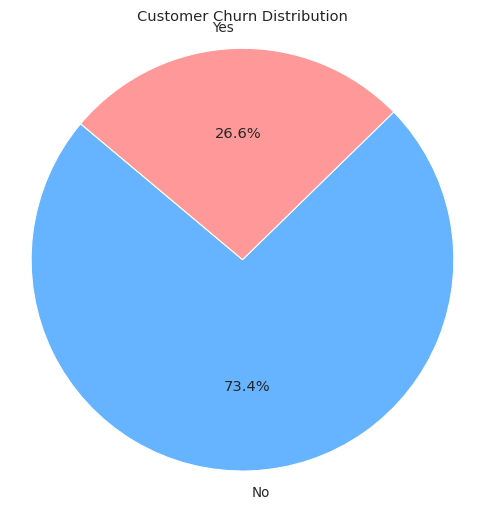

In [169]:
# 计算每类客户的数量
churn_counts = churn_data['Churn'].value_counts()

# 设置标签和颜色（可选）
labels = churn_counts.index
sizes = churn_counts.values
colors = ['#66b3ff', '#ff9999']

# 画饼图
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Customer Churn Distribution')
plt.axis('equal')  # 保证饼图是圆的
plt.show()

### 以是否流失分组，显示每组每个属性不同类别的占比

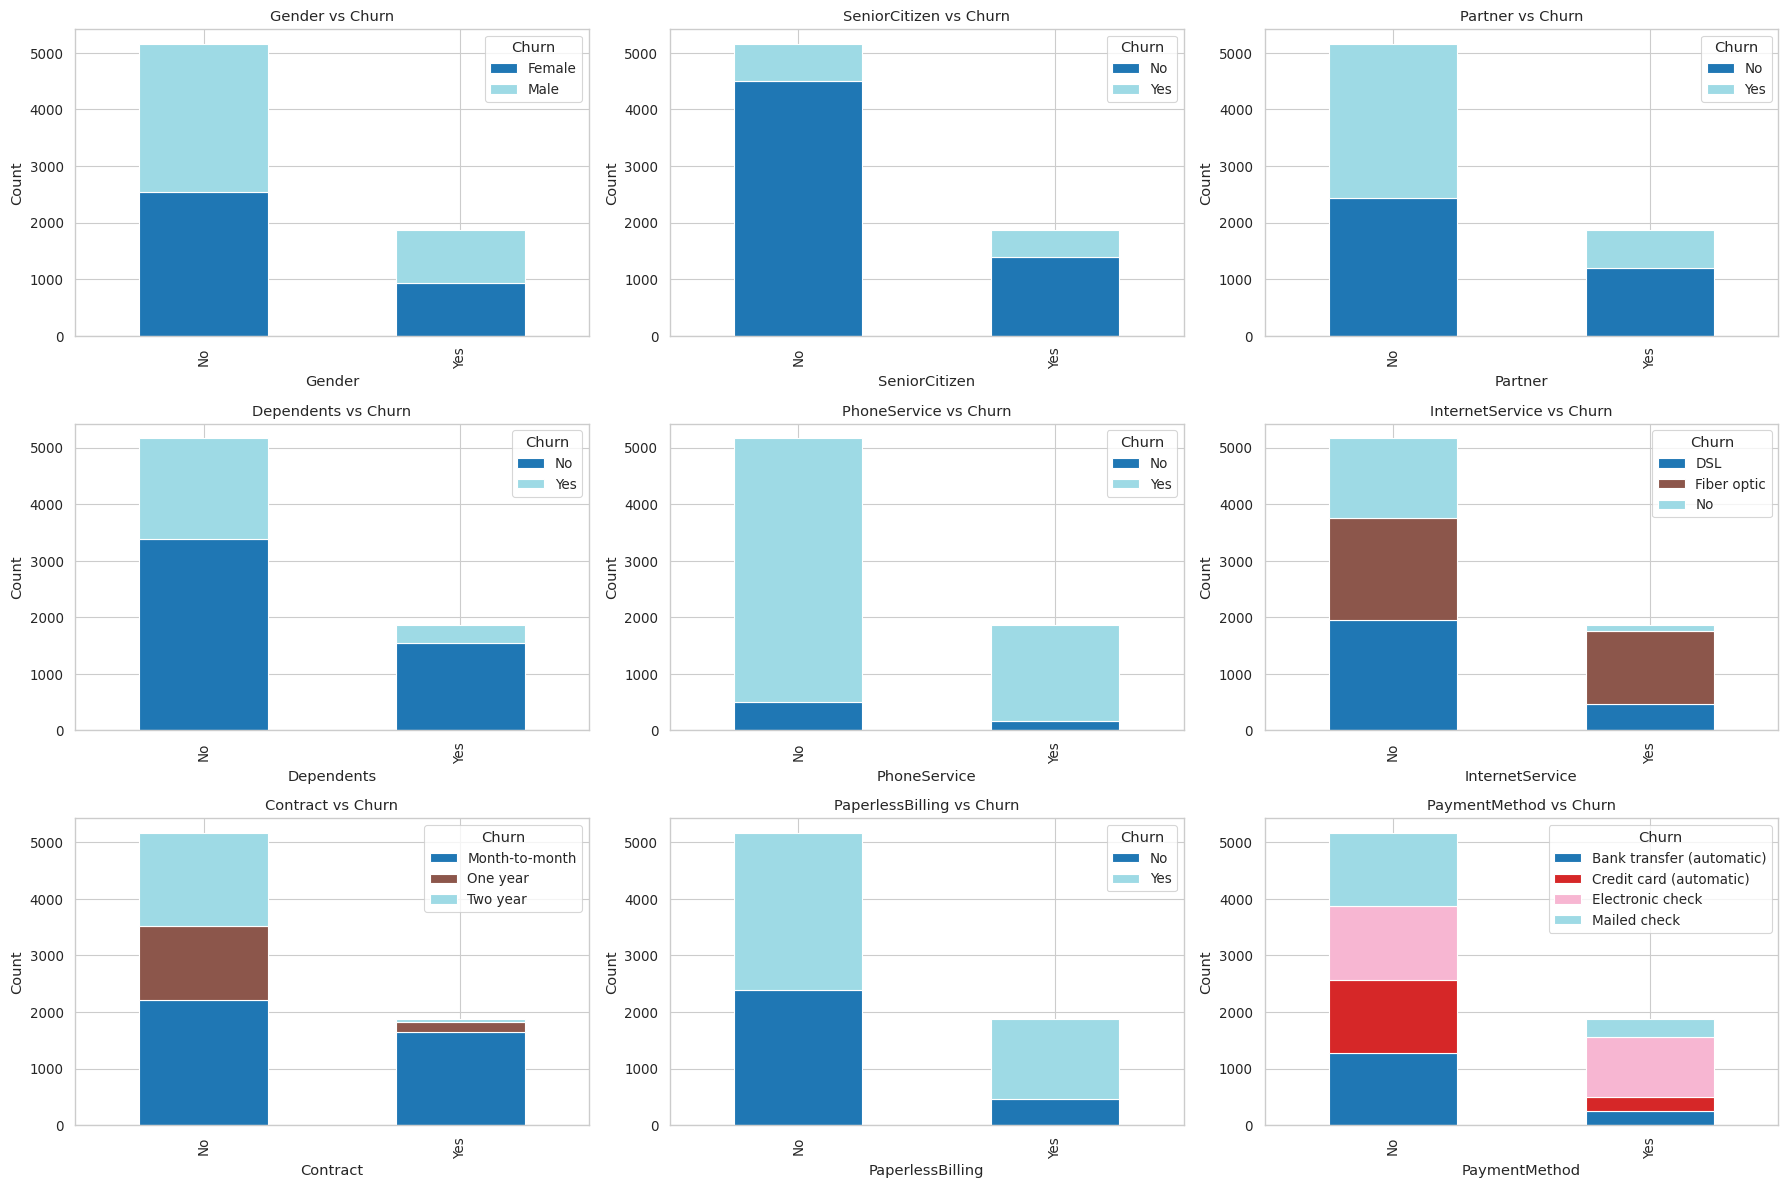

In [170]:
# 要分析的分类变量
cols = [
    'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'InternetService', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# 创建画布和子图
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  # 展平成一维，方便迭代赋图

# 逐个变量画堆叠柱状图
for i, col in enumerate(cols):
    pd.crosstab(churn_data['Churn'], churn_data[col], ).plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        colormap='tab20'  # 你也可以换其他 colormap
    )
    axes[i].set_title(f'{col} vs Churn')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Churn')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### 比较 MonthlyCharges, TotaoCharges, Tenure 在 Churn=Yes 与 No 之间的分布差异。

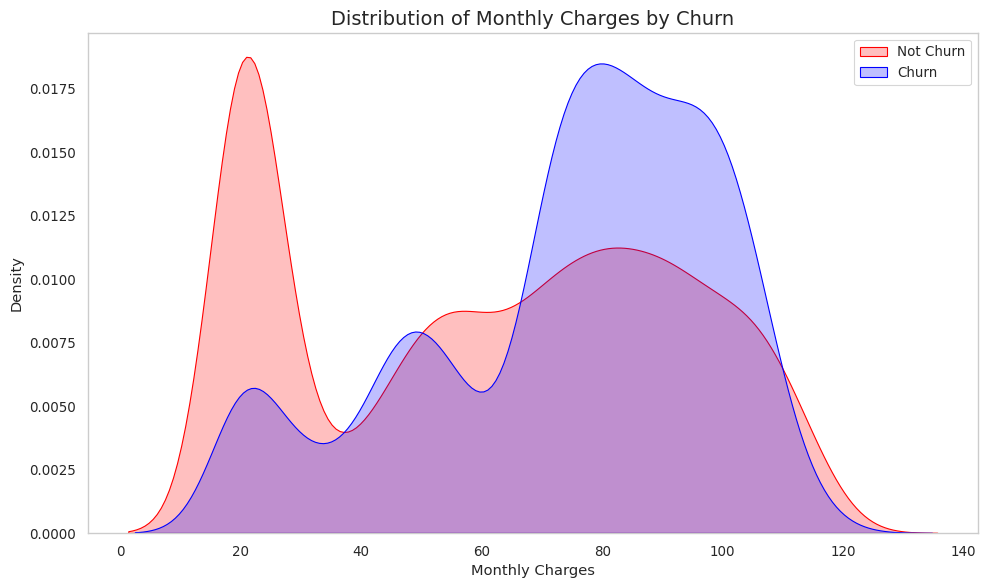

<Figure size 640x480 with 0 Axes>

In [171]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="MonthlyCharges",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="MonthlyCharges",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Monthly Charges by Churn', fontsize=14)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Density')
ax.legend(loc='upper right')
ax.grid(False)
plt.tight_layout()
plt.show()
plt.clf()

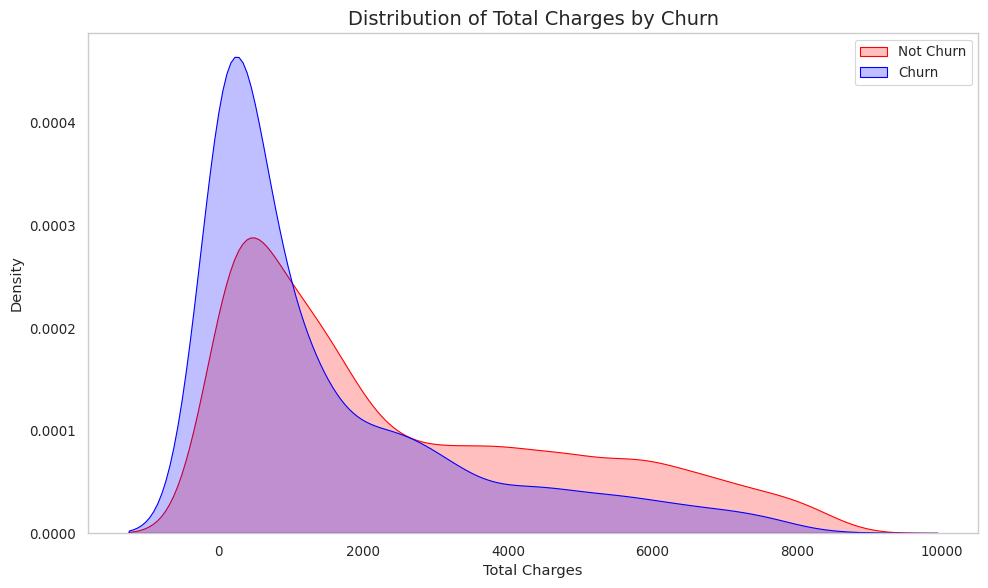

In [172]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="TotalCharges",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="TotalCharges",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Total Charges by Churn', fontsize=14)
ax.set_xlabel('Total Charges')
ax.set_ylabel('Density')
ax.legend(loc='upper right')
ax.grid(False)
plt.tight_layout()
plt.show()

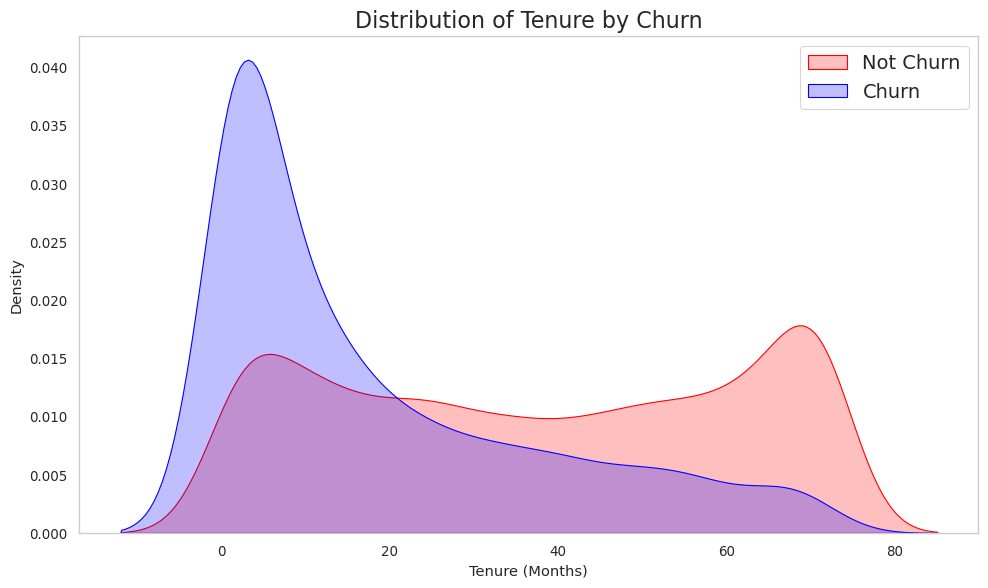

In [173]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="tenure",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="tenure",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Tenure by Churn', fontsize=16)
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Density')
ax.legend(loc='upper right', fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()

### 各个变量之间的相关性热力图

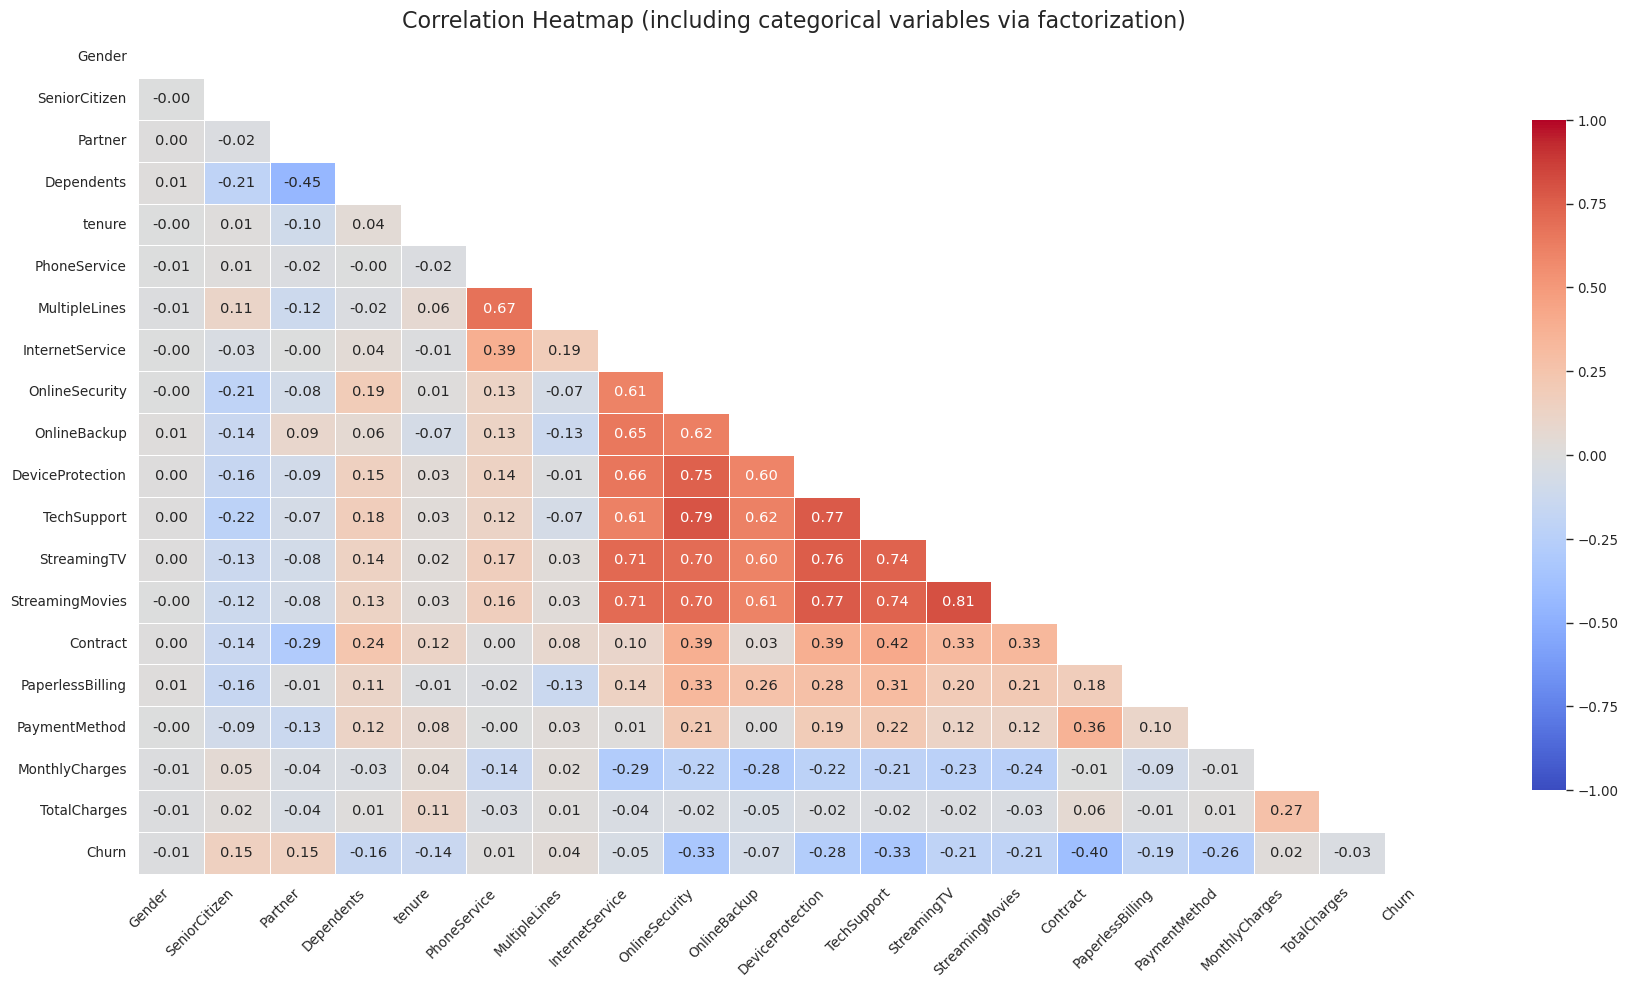

In [ ]:
# 将所有列因子化为数值（包括分类变量）
factorized_data = churn_data.apply(lambda x: pd.factorize(x)[0])

# 计算相关性
corr = factorized_data.corr()

# 创建掩码，只显示上三角
mask = np.triu(np.ones_like(corr, dtype=bool))

# 设置图形大小和风格
plt.figure(figsize=(18, 10))
sns.set_style("white")

# 绘制热力图
ax = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cbar_kws={"shrink": 0.8})

# 标题和美化
plt.title("Correlation Heatmap (including categorical variables via factorization)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
查看三个数值变量是否为偏态分布

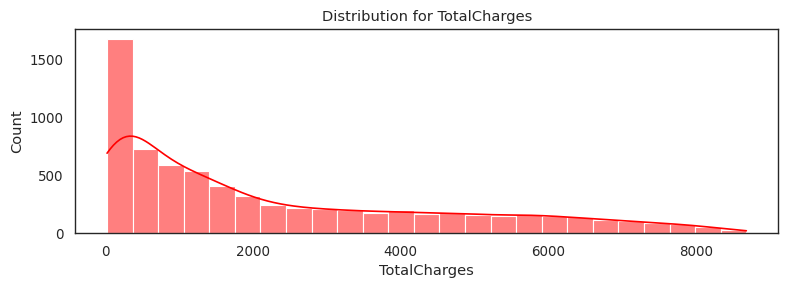

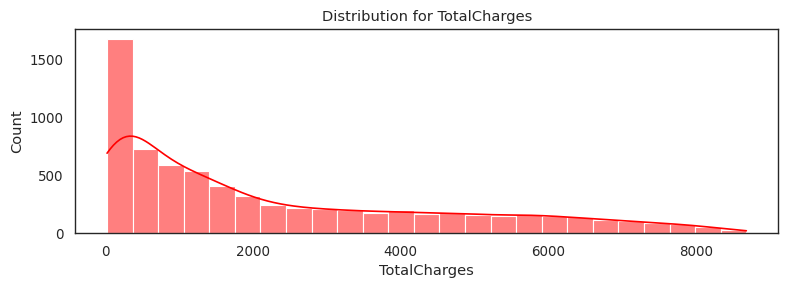

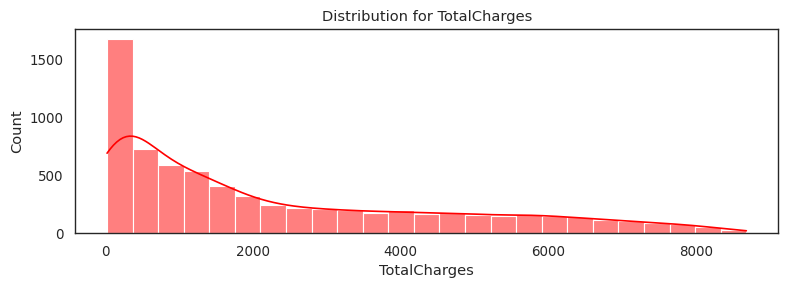

In [185]:
def distplot(feature, dataframe, color='r'):
    plt.figure(figsize=(8, 3))
    plt.title(f"Distribution for {feature}")
    sns.histplot(data=dataframe, x=feature, kde=True, color=color)
    plt.tight_layout()
    plt.show()
    
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for col in num_cols: 
    distplot(feat, churn_data)

三个数值变量非正太分布，需要做标准化处理
### 标准化处理

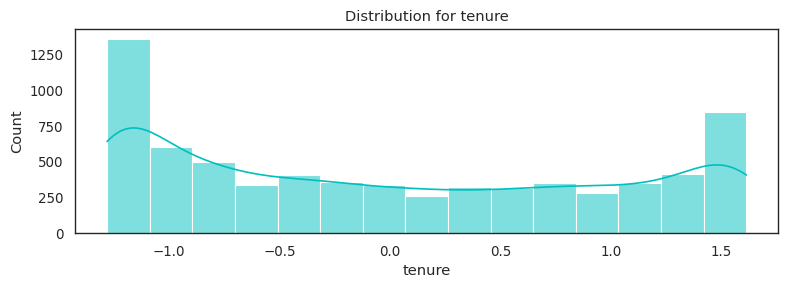

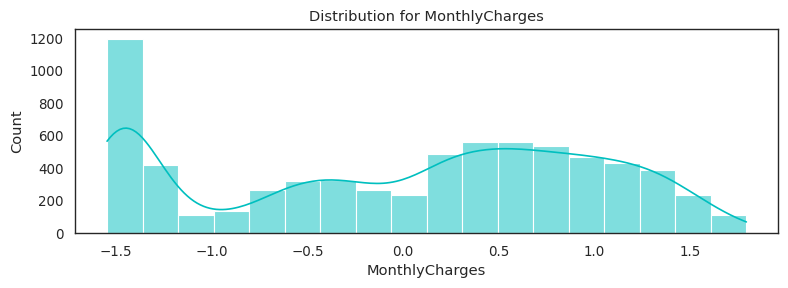

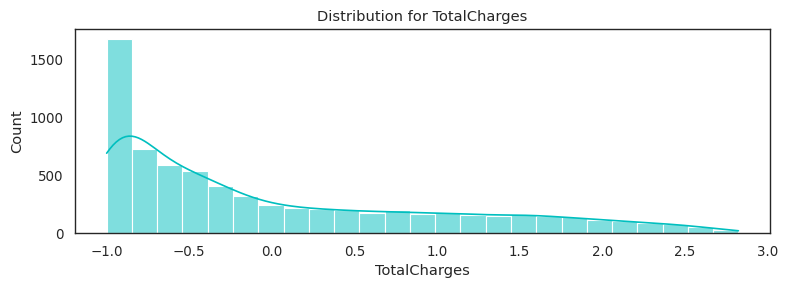

In [ ]:
churn_data_std = pd.DataFrame(StandardScaler().fit_transform(churn_data[num_cols]),columns=num_cols)
# for col in num_cols: 
#     distplot(col, churn_data_std, color='c')
    
churn_num = churn_data[num_cols].copy()

In [ ]:
cat_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']
churn_cat_encoded = pd.get_dummies(churn_data[cat_cols], drop_first=False)


In [ ]:
X = pd.concat([churn_cat_encoded, churn_num], axis=1)
y = churn_data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0).astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)